# MW-M31 Post-Merger Remnant

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Shape" data-toc-modified-id="Shape-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Shape</a></span></li><li><span><a href="#Mass-profiles" data-toc-modified-id="Mass-profiles-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Mass profiles</a></span></li><li><span><a href="#Rotation" data-toc-modified-id="Rotation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Rotation</a></span></li><li><span><a href="#Velocity-dispersion" data-toc-modified-id="Velocity-dispersion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Velocity dispersion</a></span></li><li><span><a href="#Mass-profile" data-toc-modified-id="Mass-profile-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Mass profile</a></span></li></ul></div>

## Setup

In [67]:
# import modules
import numpy as np
from numpy.linalg import norm, eigh
import pandas as pd
import astropy.units as u
from astropy.constants import G

# import plotting modules
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mpl_scatter_density
from matplotlib import rcParams

# Make the norm object to define the image stretch
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(vmin=0., vmax=1000, stretch=LogStretch())

%matplotlib inline

In [2]:
# my modules
from galaxy.galaxy import Galaxy
from galaxy.centerofmass import CenterOfMass
from galaxy.massprofile import MassProfile
from galaxy.plots import Plots
from galaxy.timecourse import TimeCourse

In [3]:
from galaxy.remnant import Remnant

In [19]:
tc = TimeCourse()

In [4]:
remnant = Remnant(usesql=True)

In [5]:
remnant.data, remnant.data.shape

(array([('M31', 2, 2.000e-05, 196.939, 24.1967, 139.881, 260.831  ,  -85.0969, -26.0921),
        ('M31', 2, 2.000e-05, 189.087, 20.2326, 146.165,  18.4025 ,   23.0247,  32.5107),
        ('M31', 2, 2.000e-05, 206.619, 19.0085, 122.444, -62.8166 , -162.355 , 181.913 ),
        ...,
        ('MW ', 3, 2.001e-05, 171.059, 13.8007, 128.251,  42.7172 ,  -34.8959,  64.3355),
        ('MW ', 3, 2.001e-05, 188.957, 23.4792, 147.111, 257.351  ,  -53.4361, -95.3574),
        ('MW ', 3, 2.001e-05, 189.534, 21.7683, 148.253,  -2.96004,   82.9176,  26.7174)],
       dtype=[('galname', '<U3'), ('type', 'u1'), ('m', '<f4'), ('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('vx', '<f4'), ('vy', '<f4'), ('vz', '<f4')]),
 (1120000,))

In [179]:
def get_counts(remnant):
    df = pd.DataFrame()
    df['gal'] = remnant.data['galname']
    df['type'] = remnant.data['type']

    # create some better column names
    types = {1: 'Halo', 2: 'Disk', 3: 'Bulge'}
    df['typename'] = df['type'].map(types)

    # get pandas to do most of the work
    df_piv = pd.pivot_table(df, values='type',
                            index='gal', columns='typename',
                            aggfunc='count', fill_value=0, margins=True)
    return df_piv

In [184]:
counts = get_counts(remnant) / 1000
counts

typename,Bulge,Disk,All
gal,,,
M31,95.0,600.0,695.0
MW,50.0,375.0,425.0
All,145.0,975.0,1120.0


In [185]:
print(counts.to_latex())

\begin{tabular}{lrrr}
\toprule
typename &  Bulge &   Disk &     All \\
gal &        &        &         \\
\midrule
M31 &   95.0 &  600.0 &   695.0 \\
MW  &   50.0 &  375.0 &   425.0 \\
All &  145.0 &  975.0 &  1120.0 \\
\bottomrule
\end{tabular}



## Shape

In [66]:
com = CenterOfMass(remnant, ptype=None)

In [7]:
xyz, vxyz = com.center_com()

In [8]:
xyz.shape

(3, 1120000)

In [11]:
def I_tensor(m, x, y, z):
    """
    Args:
        m, x, y, z:
            1-D arrays with mass and coordinates (no units)
            
    Returns:
        3x3 array representing the moment of inertia tensor
    """
    
    # 3 moments of inertia for the diagonal
    Ixx = np.sum(m*(y**2 + z**2))
    Iyy = np.sum(m*(z**2 + x**2))
    Izz = np.sum(m*(x**2 + y**2))
    
    # 3 products of inertia for symmetric off-diagonals
    Ixy = Iyx = np.sum(m*x*y)
    Ixz = Izx = np.sum(m*x*z)
    Iyz = Izy = np.sum(m*y*z)

    # assemble the tensor and return it
    I = np.array([[Ixx, Ixy, Ixz],
                  [Iyx, Iyy, Iyz],
                  [Izx, Izy, Izz]])
    return I

In [62]:
def ellipsoid_axes(m, x, y, z):
    """
    Args:
        m, x, y, z:
            1-D arrays with mass and coordinates (no units)
            
    Returns:
        Two 3-tuples: relative semimajor axes and principal axis vectors
    """
    
    I = I_tensor(m,x,y,z)
    w, v = eigh(I)
    A, B, C = w / np.max(w)
    vA, vB, vC = v
    a = np.sqrt((B-A+C)/2)
    b = np.sqrt((C-B+A)/2)
    c = np.sqrt((A-C+B)/2)
    a, b, c = (a, b, c)/a
    return (a, b, c), (vA, vB, vC)

In [118]:
def get_where(gal, ptype):
    if gal == 'MW':
        gal = 'MW ' # annoying!
    return np.where((remnant.data['galname']==gal) & (remnant.data['type']==ptype))

def sub_ellipsoid_axes(subset):
    x,y,z = (xyz.T[subset]).T
    m = remnant.data[subset]['m']

    return ellipsoid_axes(m, x, y, z)

In [111]:
MWd = get_where('MW', 2)
MWb = get_where('MW', 3)
M31d = get_where('M31', 2)
M31b = get_where('M31', 3)

In [114]:
x,y,z = xyz
m = remnant.data['m']
abc = {}
axes = {}

abc['total'], axes['total'] = ellipsoid_axes(m, x, y, z)

abc['MWd'], axes['MWd'] = sub_ellipsoid_axes(MWd)
abc['MWb'], axes['MWb'] = sub_ellipsoid_axes(MWb)
abc['M31d'], axes['M31d'] = sub_ellipsoid_axes(M31d)
abc['M31b'], axes['M31b'] = sub_ellipsoid_axes(M31b)
abc, axes

({'total': (1.0, 0.9355179066920681, 0.7736424083691683),
  'MWd': (1.0, 0.9005280163753613, 0.5280240700883598),
  'MWb': (1.0, 0.8889104042615225, 0.7611752037889253),
  'M31d': (1.0, 0.877483894748297, 0.7110574363688984),
  'M31b': (1.0, 0.7783254987701622, 0.7096328212618908)},
 {'total': (array([ 0.06962003, -0.42273688, -0.90357435], dtype=float32),
   array([-0.9963229 , -0.07480813, -0.04176731], dtype=float32),
   array([-0.04993812,  0.9031596 , -0.42639056], dtype=float32)),
  'MWd': (array([-0.44006893, -0.17750293, -0.88024545], dtype=float32),
   array([ 0.6355693 , -0.75405484, -0.16568942], dtype=float32),
   array([ 0.63434297,  0.6323718 , -0.4446515 ], dtype=float32)),
  'MWb': (array([-0.29315642, -0.41765854, -0.860012  ], dtype=float32),
   array([ 0.9529263 , -0.05482182, -0.29820472], dtype=float32),
   array([-0.07740033,  0.9069487 , -0.41406918], dtype=float32)),
  'M31d': (array([-0.22152026, -0.6402247 , -0.73555493], dtype=float32),
   array([ 0.05470886,

In [141]:
df = pd.DataFrame()

df['set'] = np.array([k for k, _ in abc.items()])
df['a'] = np.array([np.round(v[0], 2) for _, v in abc.items()])
df['b'] = np.array([np.round(v[1], 2) for _, v in abc.items()])
df['c'] = np.array([np.round(v[2], 2) for _, v in abc.items()])
print(df.to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
   set &    a &     b &     c \\
\midrule
 total &  1.0 &  0.94 &  0.77 \\
   MWd &  1.0 &  0.90 &  0.53 \\
   MWb &  1.0 &  0.89 &  0.76 \\
  M31d &  1.0 &  0.88 &  0.71 \\
  M31b &  1.0 &  0.78 &  0.71 \\
\bottomrule
\end{tabular}



In [159]:
def tilt_angle(group1, group2):
    return np.round(np.arccos(np.abs(np.dot(axes[group1][0], 
                                            axes[group2][0]))) * 180 / np.pi, 1)

In [174]:
groups = [k for k,_ in abc.items()]
tilts = pd.DataFrame([[tilt_angle(g1, g2) for g1 in groups] for g2 in groups], columns=groups)
print(groups)
tilts

['total', 'MWd', 'MWb', 'M31d', 'M31b']


,total,MWd,MWb,M31d,M31b
0,0.0,32.9,21.1,23.1,21.4
1,32.9,0.0,16.2,30.8,24.4
2,21.1,16.2,0.0,15.2,8.7
3,23.1,30.8,15.2,0.0,6.5
4,21.4,24.4,8.7,6.5,0.0


In [175]:
print(tilts.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  total &   MWd &   MWb &  M31d &  M31b \\
\midrule
0 &    0.0 &  32.9 &  21.1 &  23.1 &  21.4 \\
1 &   32.9 &   0.0 &  16.2 &  30.8 &  24.4 \\
2 &   21.1 &  16.2 &   0.0 &  15.2 &   8.7 \\
3 &   23.1 &  30.8 &  15.2 &   0.0 &   6.5 \\
4 &   21.4 &  24.4 &   8.7 &   6.5 &   0.0 \\
\bottomrule
\end{tabular}



## Mass profiles

In [ ]:
snap = 801
g = Remnant(snap=snap, usesql=True, ptype=(1,2,3))
mp = MassProfile(g)
t = tc.snap2time(snap)

In [46]:
fitted_a = mp.fit_hernquist_a()
fitted_a

<Quantity 84.5 kpc>

In [43]:
radii = np.linspace(0.1, 30) * u.kpc

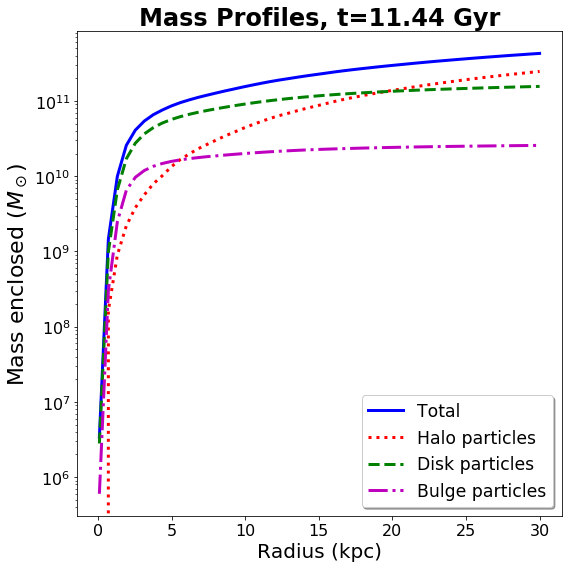

In [44]:
fig = plt.figure(figsize=(8,8))

ax = plt.subplot()

# add the curves
ax.semilogy(radii, mp.mass_enclosed_total(radii), 'b-', lw=3, 
            label='Total')
ax.semilogy(radii, mp.mass_enclosed(radii, 1), 'r:', lw=3, 
            label='Halo particles')
ax.semilogy(radii, mp.mass_enclosed(radii, 2), 'g--', lw=3, 
            label='Disk particles')
ax.semilogy(radii, mp.mass_enclosed(radii, 3), 'm-.', lw=3, 
            label='Bulge particles')

#adjust tick label font size
label_size = 16
rcParams['xtick.labelsize'] = label_size 
rcParams['ytick.labelsize'] = label_size

# Add labels and subplot title
ax.set_xlabel('Radius (kpc)', fontsize=20)
ax.set_ylabel(r'Mass enclosed ($M_\odot$)', fontsize=22)
ax.legend(loc='lower right',fontsize='xx-large', shadow=True)

#set axis limits
# ax.set_ylim(ylim[0], ylim[1])

# Overall title
ax.set_title(f'Mass Profiles, t={t:.2f} Gyr', y=1.0, 
            fontsize=24, weight='bold')
plt.tight_layout()

In [18]:
L, pos, v = com.angular_momentum()
L

array([ 1.6242846e+08, -7.1358522e+08, -4.9119174e+08], dtype=float32)

In [19]:
xyz_rot, vxyz_rot = com.rotate_frame()

/home/colin/.pyenv/versions/miniconda3-4.2.12/envs/400b/lib/python3.6/site-packages/mpl_scatter_density/generic_density_artist.py:74: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/colin/.pyenv/versions/miniconda3-4.2.12/envs/400b/lib/python3.6/site-packages/mpl_scatter_density/generic_density_artist.py:79: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


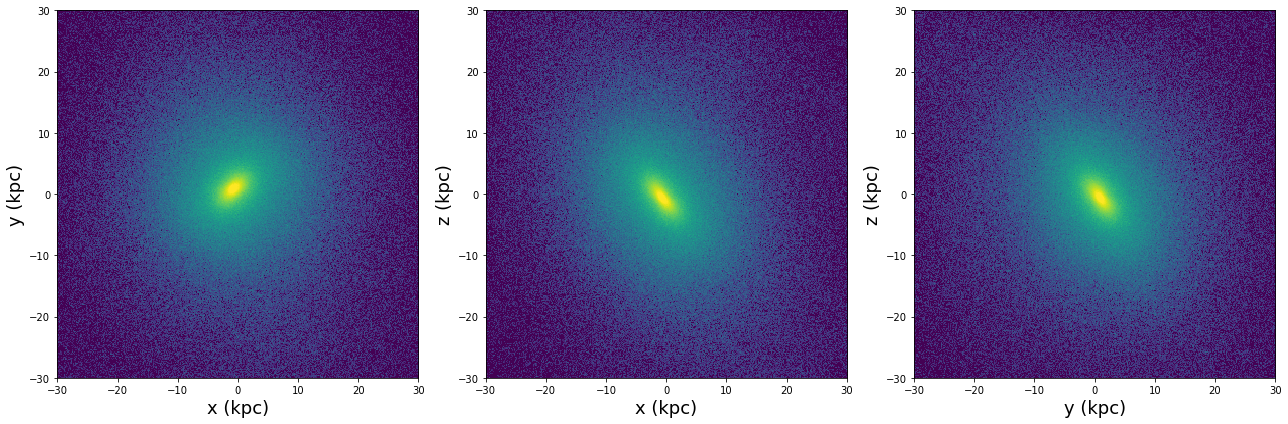

In [20]:
fig = plt.figure(figsize=(18,6))

lim = 30 # axes +/- lim
fontsize = 18 # for labels

# left plot x-y
ax0 = fig.add_subplot(1, 3, 1, projection='scatter_density')
ax0.scatter_density(xyz_rot[0], xyz_rot[1], norm=norm)

ax0.set_xlim(-lim, lim)
ax0.set_ylim(-lim, lim)

ax0.set_xlabel('x (kpc)', fontsize=fontsize)
ax0.set_ylabel('y (kpc)', fontsize=fontsize)

# mid plot x-z
ax1 = fig.add_subplot(1, 3, 2, projection='scatter_density')
ax1.scatter_density(xyz_rot[0], xyz_rot[2], norm=norm)

ax1.set_xlim(-lim, lim)
ax1.set_ylim(-lim, lim)

ax1.set_xlabel('x (kpc)', fontsize=fontsize)
ax1.set_ylabel('z (kpc)', fontsize=fontsize)

# right plot y-z
ax2 = fig.add_subplot(1, 3, 3, projection='scatter_density')
ax2.scatter_density(xyz_rot[1], xyz_rot[2], norm=norm)

ax2.set_xlim(-lim, lim)
ax2.set_ylim(-lim, lim)

ax2.set_xlabel('y (kpc)', fontsize=fontsize)
ax2.set_ylabel('z (kpc)', fontsize=fontsize);

#adjust tick label font size
label_size = 16
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size
plt.tight_layout()
plt.savefig('remnant_shape.pdf', rasterized=True, dpi=350);

## Rotation

/home/colin/.pyenv/versions/miniconda3-4.2.12/envs/400b/lib/python3.6/site-packages/mpl_scatter_density/generic_density_artist.py:74: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/colin/.pyenv/versions/miniconda3-4.2.12/envs/400b/lib/python3.6/site-packages/mpl_scatter_density/generic_density_artist.py:79: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


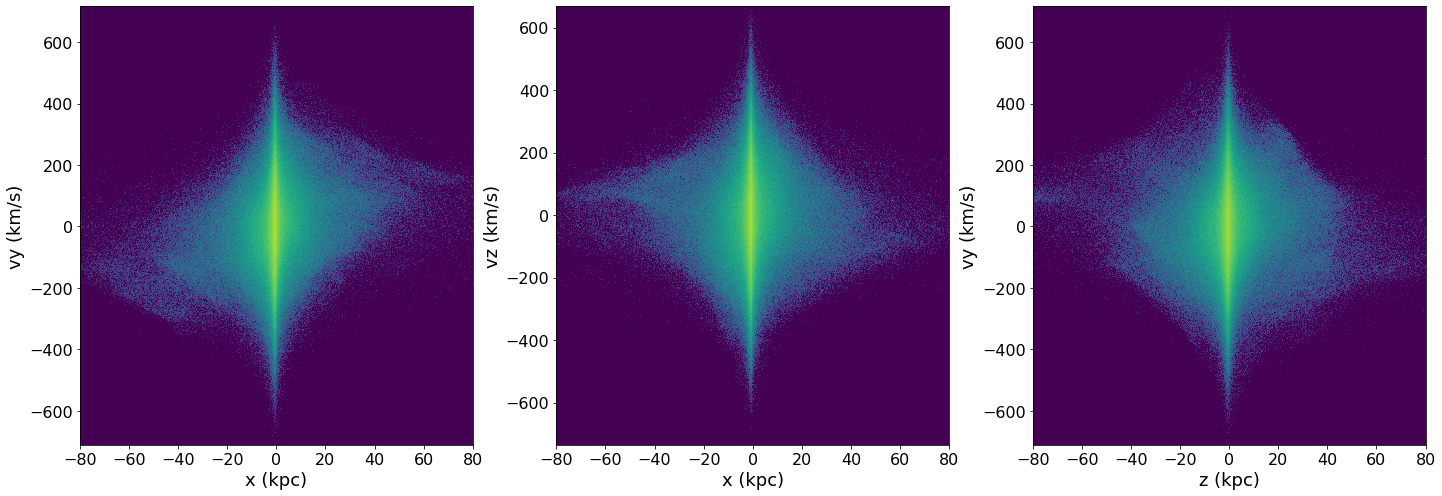

In [21]:
fig = plt.figure(figsize=(20,7))

lim = 80 # axes +/- lim
fontsize = 18 # for labels

# left plot x-vy
ax0 = fig.add_subplot(1, 3, 1, projection='scatter_density')
ax0.scatter_density(xyz_rot[0], vxyz_rot[1], norm=norm)

ax0.set_xlim(-lim, lim)
# ax0.set_ylim(-lim, lim)

ax0.set_xlabel('x (kpc)', fontsize=fontsize)
ax0.set_ylabel('vy (km/s)', fontsize=fontsize)

# mid plot x-vz
ax1 = fig.add_subplot(1, 3, 2, projection='scatter_density')
ax1.scatter_density(xyz_rot[0], vxyz_rot[2], norm=norm)

ax1.set_xlim(-lim, lim)
# ax1.set_ylim(-lim, lim)

ax1.set_xlabel('x (kpc)', fontsize=fontsize)
ax1.set_ylabel('vz (km/s)', fontsize=fontsize);

# right plot z-vy
ax1 = fig.add_subplot(1, 3, 3, projection='scatter_density')
ax1.scatter_density(xyz_rot[2], vxyz_rot[1], norm=norm)

ax1.set_xlim(-lim, lim)
# ax1.set_ylim(-lim, lim)

ax1.set_xlabel('z (kpc)', fontsize=fontsize)
ax1.set_ylabel('vy (km/s)', fontsize=fontsize);
plt.tight_layout()
plt.savefig('remnant_phase.pdf', rasterized=True, dpi=350);

/home/colin/.pyenv/versions/miniconda3-4.2.12/envs/400b/lib/python3.6/site-packages/mpl_scatter_density/generic_density_artist.py:74: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/colin/.pyenv/versions/miniconda3-4.2.12/envs/400b/lib/python3.6/site-packages/mpl_scatter_density/generic_density_artist.py:79: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


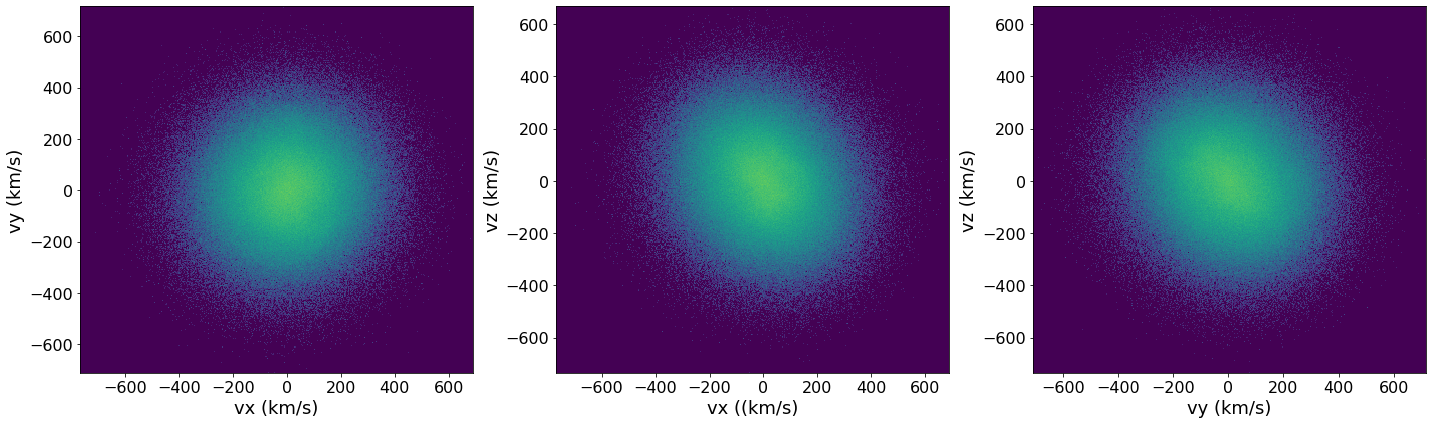

In [23]:
fig = plt.figure(figsize=(20,6))

lim = 80 # axes +/- lim
fontsize = 18 # for labels

# left plot x-vy
ax0 = fig.add_subplot(1, 3, 1, projection='scatter_density')
ax0.scatter_density(vxyz_rot[0], vxyz_rot[1], norm=norm)

# ax0.set_xlim(-lim, lim)
# ax0.set_ylim(-lim, lim)

ax0.set_xlabel('vx (km/s)', fontsize=fontsize)
ax0.set_ylabel('vy (km/s)', fontsize=fontsize)

# mid plot x-vz
ax1 = fig.add_subplot(1, 3, 2, projection='scatter_density')
ax1.scatter_density(vxyz_rot[0], vxyz_rot[2], norm=norm)

# ax1.set_xlim(-lim, lim)
# ax1.set_ylim(-lim, lim)

ax1.set_xlabel('vx ((km/s)', fontsize=fontsize)
ax1.set_ylabel('vz (km/s)', fontsize=fontsize);

# right plot z-vy
ax1 = fig.add_subplot(1, 3, 3, projection='scatter_density')
ax1.scatter_density(vxyz_rot[1], vxyz_rot[2], norm=norm)

# ax1.set_xlim(-lim, lim)
# ax1.set_ylim(-lim, lim)

ax1.set_xlabel('vy (km/s)', fontsize=fontsize)
ax1.set_ylabel('vz (km/s)', fontsize=fontsize)
plt.tight_layout();


## Velocity dispersion

## Mass profile